# 06: Face pose dlib/MTCNN

In [8]:
import os
import os.path as osp
from os.path import join
from glob import glob
import random

import cv2 as cv
import numpy as np
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import math
import dlib
from mtcnn.mtcnn import MTCNN

%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import im_utils
from app.models.bbox import BBox

In [31]:
def detect_faces_dlib(im,pyramids=0):
    rects = detector_dlib(im, pyramids)
    faces = [ (r.left(),r.top(),r.right(),r.bottom()) for r in rects] #x1,y1,x2,y2
    return faces

In [45]:
def detect_faces_mtcnn(im):
  dets = detector_mtcnn.detect_faces(im)
  rois = []
  dim = im.shape[:2][::-1]
  for det in dets:
    rect = det['box']
    keypoints = det['keypoints']  # not using here. see 'face_landmarks.py'
    bbox = BBox.from_xywh_dim(*rect, dim)
    rois.append({'bbox':bbox, 'landmarks': keypoints})
  return rois

In [33]:
# init mtcnn
detector_mtcnn = MTCNN()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [34]:
# init dlib
dlib_predictor_path = osp.join(cfg.DIR_MODELS_DLIB_68PT)
predictor = dlib.shape_predictor(dlib_predictor_path)
detector_dlib = dlib.get_frontal_face_detector()

In [35]:
# get image files
dir_im = '/data_store/datasets/people/lfw/images/'
fp_ims = glob(join(dir_im, '**/*.jpg'),recursive=True)

/data_store/datasets/people/lfw/images/Calista_Flockhart/Calista_Flockhart_0005.jpg


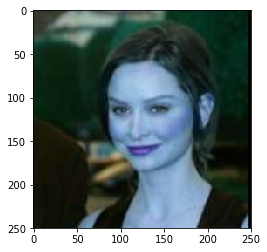

In [106]:
fp_im = np.random.choice(fp_ims)
im = cv.imread(fp_im)
plt.imshow(im)
print(fp_im)

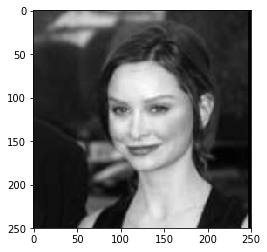

In [107]:
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im_gray, cmap='gray')

In [108]:
# Draw high-confidence faces
faces_dlib = detect_faces_dlib(im,pyramids=0)
print("Found {} face(s)".format(len(faces)))

Found 1 face(s)


In [109]:
dets_mtcnn = detect_faces_mtcnn(im)
print("Found {} face(s)".format(len(dets_mtcc)))

Found 1 face(s)


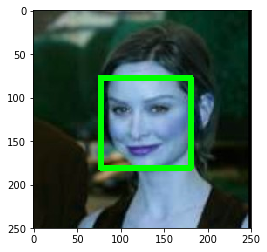

In [110]:
# Draw faces dlib
dst = im.copy()
for face in faces_dlib:
    x1,y1,x2,y2 = face
    cv2.rectangle(dst,(x1,y1),(x2,y2),(0,255,0),6)

title='dlib detect: {} detections'.format(len(faces))
plt.imshow(dst)

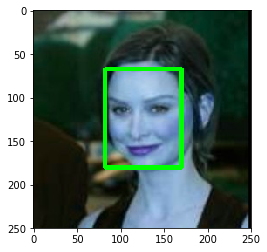

In [111]:
# Draw faces mtcnn
dst = im.copy()
dim = im.shape[:2][::-1]
for det in dets_mtcnn:
  bbox = det['bbox'].to_dim(dim)
  cv2.rectangle(dst,bbox.pt_tl, bbox.pt_br, (0,255,0),3)
plt.imshow(dst)

In [112]:
# Copied from https://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/
def get_pose_dlib(img, pose_points):
  size = img.shape
  # Camera internals
  focal_length = size[1]
  center = (size[1]/2, size[0]/2)
  camera_matrix = np.array(
      [[focal_length, 0, center[0]],
      [0, focal_length, center[1]],
      [0, 1, 1]], dtype = "double"
  )

  dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
  (success, rot_vec, tran_vec) = cv2.solvePnP(
  model_points, pose_points, 
  camera_matrix, dist_coeffs, 
  flags=cv2.SOLVEPNP_ITERATIVE)

  # Project a 3D point (0, 0, 1000.0) onto the image plane.
  # We use this to draw a line sticking out of the nose
  return (success, rot_vec, tran_vec,camera_matrix)

In [113]:
regions = {
    "outside_mouth": {
        "points": list(range(49, 60+1)),
        "closed": True
        },
    "inside_mouth": {
        "points": list(range(61, 68)),
        "closed": True
        },
    "brow_left": {
        "points": list(range(18, 22+1)),
        "closed": False
        },
    "brow_right": {
        "points": list(range(23, 27+1)),
        "closed": False
        },
    "eye_right": {
        "points": list(range(37, 42+1)),
        "closed": True
        },
    "eye_left": {
        "points": list(range(43, 48+1)),
        "closed": True
        },
    "nose_bottom": {
        "points": list(range(31,36+1)),
        "closed": True
        },
    "nose_bridge": {
        "points": list(range(28,31+1)),
        "closed": False
        },
    "jaw": {
        "points": list(range(1, 17+1)),
        "closed": False
    }
}

In [114]:
roi = faces[0] #biggest face
# Convert back to dlib.rectangle for predictor
roi_dlib = dlib.rectangle(face[0],face[1],face[2],face[3])
landmarks = [[p.x, p.y] for p in predictor(im_gray, roi_dlib).parts()]

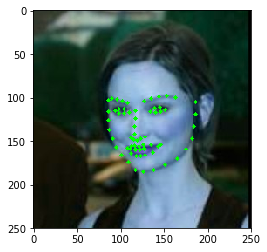

In [115]:
# Draw landmarks as dots
dst = im.copy()
for lm in landmarks:
    cv2.circle(dst,(lm[0],lm[1]), 2, (0,255,0), -1)

#imx.pltimg(dst,mode='bgr',title='Facial Landmarks (dots)')
plt.imshow(dst)

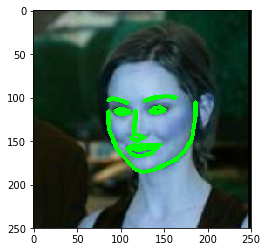

In [116]:
# Draw landmarks as lines in groups
dst = im.copy()

rclosed = False
for region in regions:
    x2 = None
    y2 = None
    rclosed = regions[region]['closed']
    for pt in regions[region]['points']:
        pos = landmarks[pt-1]
        x1,y1 = (landmarks[pt-1][0],landmarks[pt-1][1])
        if x2 is not None:
             cv2.line(dst,(x1,y1),(x2,y2),(0,255,0), 4)
        x2,y2 = (x1,y1)
        
    if rclosed:
        pt = regions[region]['points'][0]
        x2,y2 = (landmarks[pt-1][0],landmarks[pt-1][1])
        cv2.line(dst,(x1,y1),(x2,y2),(0,255,0), 4)
        
#imx.pltimg(dst,mode='bgr',title='Facial Landmarks (lines)')
plt.imshow(dst)

pitch: -10.7890555409979, roll: 22.905969823333773, yaw: 2.9906363814065204
[[[191.68020825 140.30162719]]]


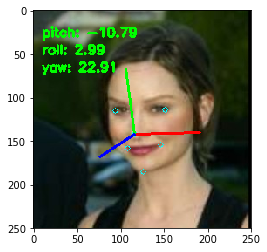

In [122]:
dst = im.copy()

pose_points_idx = (30,8,36,45,48,54)

# 3D model points.
model_points = np.array([
    (0.0, 0.0, 0.0),             # Nose tip
    (0.0, -330.0, -65.0),        # Chin
    (-225.0, 170.0, -135.0),     # Left eye left corner
    (225.0, 170.0, -135.0),      # Right eye right corne
    (-150.0, -150.0, -125.0),    # Left Mouth corner
    (150.0, -150.0, -125.0)      # Right mouth corner
])
dist_coeffs = np.zeros((4,1))
rot_vec = None
size = im_gray.shape

pose_points = []
for j,pidx in enumerate(pose_points_idx):
    landmarks = [[p.x, p.y] for p in predictor(im_gray, roi_dlib).parts()]
    ff = landmarks[pidx]
    pose_points.append((ff[0],ff[1]))

pose_points = np.array(pose_points, dtype='double')
(success, rot_vec, tran_vec, cam_mat) = get_pose_dlib(im_gray, pose_points)

# --------------------------------
axis = np.float32([[500,0,0], 
                      [0,500,0], 
                      [0,0,500]])

imgpts, jac = cv.projectPoints(axis, rot_vec, tran_vec, cam_mat, dist_coeffs)
modelpts, jac2 = cv.projectPoints(model_points, rot_vec, tran_vec, cam_mat, dist_coeffs)
rvec_matrix = cv.Rodrigues(rot_vec)[0]

proj_matrix = np.hstack((rvec_matrix, tran_vec))
eulerAngles = cv.decomposeProjectionMatrix(proj_matrix)[6] 

pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]

pitch = math.degrees(math.asin(math.sin(pitch)))
roll = -math.degrees(math.asin(math.sin(roll)))
yaw = math.degrees(math.asin(math.sin(yaw)))

print('pitch: {}, roll: {}, yaw: {}'.format(pitch, yaw, roll))

# --------------------------------
  
  
if success:
    # X vector
    (nose_end_point2D_x, jacobian) = cv.projectPoints(
        np.array([(500.0, 0.0, 0)]),
        rot_vec, 
        tran_vec, 
        cam_mat,
        dist_coeffs)
    # Y vector
    (nose_end_point2D_y, jacobian) = cv.projectPoints(
        np.array([(0.0, 500.0, 0)]),
        rot_vec, 
        tran_vec, 
        cam_mat,
        dist_coeffs)
    # Z vector
    (nose_end_point2D_z, jacobian) = cv.projectPoints(
        np.array([(0.0, 0.0, 500.0)]),
        rot_vec, 
        tran_vec, 
        cam_mat,
        dist_coeffs)
    
    
for x,y in pose_points:
    cv.circle(dst,(int(x),int(y)),3,(255,255,0))

# X
print(nose_end_point2D_x)
p1 = ( int(pose_points[0][0]), int(pose_points[0][1]))
p2 = ( int(nose_end_point2D_x[0][0][0]), int(nose_end_point2D_x[0][0][1]))
cv.line(dst,p1,p2,(0,0,255),2)

# Y
p1 = ( int(pose_points[0][0]), int(pose_points[0][1]))
p2 = ( int(nose_end_point2D_y[0][0][0]), int(nose_end_point2D_y[0][0][1]))
cv.line(dst,p1,p2,(0,255,0),2)

# Z
p1 = ( int(pose_points[0][0]), int(pose_points[0][1]))
p2 = ( int(nose_end_point2D_z[0][0][0]), int(nose_end_point2D_z[0][0][1]))
cv.line(dst,p1,p2,(255,0,0),2)

#imx.pltimg(dst,mode='bgr',title='Head Pose')
cv.putText(dst, 'pitch: {:.2f}'.format(pitch), (10,30),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 0), thickness=2, lineType=2)
cv.putText(dst, 'roll: {:.2f}'.format(roll), (10,50),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 0), thickness=2, lineType=2)
cv.putText(dst, 'yaw: {:.2f}'.format(yaw), (10,70),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 0), thickness=2, lineType=2)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

In [119]:
def face_orientation(frame, landmarks):
  
  size = frame.shape #(height, width, color_channel)
  
  image_points = np.array([
                          (landmarks[4], landmarks[5]),     # Nose tip
                          (landmarks[10], landmarks[11]),   # Chin
                          (landmarks[0], landmarks[1]),     # Left eye left corner
                          (landmarks[2], landmarks[3]),     # Right eye right corne
                          (landmarks[6], landmarks[7]),     # Left Mouth corner
                          (landmarks[8], landmarks[9])      # Right mouth corner
                      ], dtype="double")

  model_points = np.array([
                          (0.0, 0.0, 0.0),             # Nose tip
                          (0.0, -330.0, -65.0),        # Chin
                          (-165.0, 170.0, -135.0),     # Left eye left corner
                          (165.0, 170.0, -135.0),      # Right eye right corne
                          (-150.0, -150.0, -125.0),    # Left Mouth corner
                          (150.0, -150.0, -125.0)      # Right mouth corner                         
                      ])

  # Camera internals

  center = (size[1]/2, size[0]/2)
  focal_length = center[0] / np.tan(60/2 * np.pi / 180)
  camera_matrix = np.array(
                       [[focal_length, 0, center[0]],
                       [0, focal_length, center[1]],
                       [0, 0, 1]], dtype = "double"
                       )

  dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
  (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.CV_ITERATIVE)


  axis = np.float32([[500,0,0], 
                        [0,500,0], 
                        [0,0,500]])

  imgpts, jac = cv2.projectPoints(axis, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
  modelpts, jac2 = cv2.projectPoints(model_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
  rvec_matrix = cv2.Rodrigues(rotation_vector)[0]

  proj_matrix = np.hstack((rvec_matrix, translation_vector))
  eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 


  pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


  pitch = math.degrees(math.asin(math.sin(pitch)))
  roll = -math.degrees(math.asin(math.sin(roll)))
  yaw = math.degrees(math.asin(math.sin(yaw)))

  return imgpts, modelpts, (str(int(roll)), str(int(pitch)), str(int(yaw))), (landmarks[4], landmarks[5])


pointgs are in 
```
[image_path, left_eyes_x, left_eyes_y, right_eyes_x, right_eyes_y, nose_x, nose_y, left_mouth_x, left_mouth_y, right_mouth_x, right_mouth_y, chin_x, chin_y]
```

In [120]:
dets_mtcnn[0]['landmarks']

{'left_eye': (101, 115),
 'mouth_left': (109, 157),
 'mouth_right': (144, 155),
 'nose': (119, 140),
 'right_eye': (144, 112)}

In [121]:
landmarks = dets_mtcnn[]

SyntaxError: invalid syntax (<ipython-input-121-3791c0ea7689>, line 1)

In [ ]:
print img_path
  imgpts, modelpts, rotate_degree, nose = face_orientation(frame, landmarks)

  cv2.line(frame, nose, tuple(imgpts[1].ravel()), (0,255,0), 3) #GREEN
  cv2.line(frame, nose, tuple(imgpts[0].ravel()), (255,0,), 3) #BLUE
  cv2.line(frame, nose, tuple(imgpts[2].ravel()), (0,0,255), 3) #RED

  remapping = [2,3,0,4,5,1]
  for index in range(len(landmarks)/2):
      random_color = tuple(np.random.random_integers(0,255,size=3))

      cv2.circle(frame, (landmarks[index*2], landmarks[index*2+1]), 5, random_color, -1)  
      cv2.circle(frame,  tuple(modelpts[remapping[index]].ravel().astype(int)), 2, random_color, -1)  


#    cv2.putText(frame, rotate_degree[0]+' '+rotate_degree[1]+' '+rotate_degree[2], (10, 30),
#                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0),
#                thickness=2, lineType=2)

  for j in xrange(len(rotate_degree)):
              cv2.putText(frame, ('{:05.2f}').format(float(rotate_degree[j])), (10, 30 + (50 * j)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2, lineType=2)

  cv2.imwrite('test2/'+img_path.split('/')[1], frame)

In [ ]:
a = '/data_store/'
from pathlib import Path
b = Path(a)

In [ ]:
b.is_dir()
help(Path.mkdir)

In [ ]:
b.is_file()